In [82]:
%matplotlib inline

import zipline
from zipline.api import order_target_percent, symbol,  \
    set_commission, set_slippage, schedule_function, \
    date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from scipy import stats  
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

"""
Model Settings
"""
intial_portfolio = 50000
momentum_window = 140
minimum_momentum = 12
portfolio_size = 6
vola_window = 80

"""
Commission and Slippage Settings
"""
enable_commission = False
commission_pct = 0.001
enable_slippage = False
slippage_volume_limit = 0.25
slippage_impact = 0.1

"""
Helper functions.
"""

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    # Make a list of consecutive numbers
    x = np.arange(len(ts)) 
    # Get logs
    log_ts = np.log(ts)
    # Calculate regression values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    if slope < 0:
        return -100
    # Annualize percent
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    #Adjust for fitness
    score = annualized_slope * (r_value ** 2)
    return score

def volatility(ts):
    return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):
    """
    Output some performance numbers during backtest run
    This code just prints out the past month's performance
    so that we have something to look at while the backtest runs.
    """
    
    # Get today's date
    today = zipline.api.get_datetime().date()
    
    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

"""
Initialization and trading logic
"""
def initialize(context):
   
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
    else:
        slippage_model=FixedSlippage(spread=0.0)   
    set_slippage(slippage_model)    
    
    # Used only for progress output.
    context.last_month = intial_portfolio
    
    # Fetch and store index membership
    context.index_members = pd.read_csv('index_constituents/nifty_constituents.csv', index_col=0, parse_dates=[0])
    
    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )
    
def rebalance(context, data):
    # Write some progress output during the backtest
    output_progress(context)
    
    # Ok, let's find which stocks can be traded today.

    # First, get today's date
    today = zipline.api.get_datetime()
    
    # Second, get the index makeup for all days prior to today.
    all_prior = context.index_members.loc[context.index_members.index < today]
    
    # Now let's snag the first column of the last, i.e. latest, entry.
    latest_day = all_prior.iloc[-1,0]
    
    # Split the text string with tickers into a list
    list_of_tickers = latest_day.split(',')
    # Finally, get the Zipline symbols for the tickers
    todays_universe = [symbol(ticker) for ticker in list_of_tickers]
    # There's your daily universe. But we could of course have done this in one go.
    """       
    
    # This line below does the same thing,
    # using the same logic to fetch today's stocks.
    
    todays_universe = [
        symbol(ticker) for ticker in 
        context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
    ]
    """    
    
    # Get historical data
    hist = data.history(todays_universe, "close", momentum_window, "1d")
    hist.dropna(inplace=True)
    # Make momentum ranking table
    ranking_table = hist.apply(momentum_score).sort_values(ascending=False)
    
    """
    Sell Logic
    
    First we check if any existing position should be sold.
    * Sell if stock is no longer part of index.
    * Sell if stock has too low momentum value.
    """
    kept_positions = list(context.portfolio.positions.keys())
    for security in context.portfolio.positions:
        if (security not in todays_universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)          
        elif ranking_table[security] < minimum_momentum:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)         
      
    
    """
    Stock Selection Logic
    
    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[
        ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
    
    new_portfolio = pd.concat(
        (buy_list, 
         ranking_table.loc[ranking_table.index.isin(kept_positions)])
    )
    

    """
    Calculate inverse volatility for stocks, 
    and make target position weights.
    """
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    print(vola_target_weights)
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            order_target_percent(security, weight)
            print('Rebalance existing position - ', security, weight)
        else:
            if ranking_table[security] > minimum_momentum:
                order_target_percent(security, weight)
                print('Buying new position - ', security, weight)

def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return   
        
start = datetime(2015, 1, 1, tzinfo=pytz.UTC)
end = datetime(2020, 7, 2, tzinfo=pytz.UTC)
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio,  
    data_frequency = 'daily', 
    bundle='nse_data' ) 



2015-01-02 - Last Month Result: 0.00%
Equity(206 [HINDPETRO])     0.115152
Equity(100 [CIPLA])         0.150399
Equity(74 [BOSCHLTD])       0.166924
Equity(236 [INDUSINDBK])    0.204503
Equity(64 [BHARATFORG])     0.128520
Equity(312 [MARUTI])        0.234502
dtype: float64
Buying new position -  Equity(206 [HINDPETRO]) 0.1151516271176761
Buying new position -  Equity(100 [CIPLA]) 0.15039906002466444
Buying new position -  Equity(74 [BOSCHLTD]) 0.16692364252168737
Buying new position -  Equity(236 [INDUSINDBK]) 0.204503346451077
Buying new position -  Equity(64 [BHARATFORG]) 0.12852030150857224
Buying new position -  Equity(312 [MARUTI]) 0.2345020223763228
2015-02-02 - Last Month Result: 6.98%
Equity(296 [LICHSGFIN])     0.120405
Equity(236 [INDUSINDBK])    0.218953
Equity(206 [HINDPETRO])     0.112214
Equity(312 [MARUTI])        0.237172
Equity(100 [CIPLA])         0.181934
Equity(64 [BHARATFORG])     0.129322
dtype: float64
Buying new position -  Equity(296 [LICHSGFIN]) 0.12040508620

C:\Users\msreeni\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\msreeni\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


Rebalance existing position -  Equity(236 [INDUSINDBK]) 0.21895337675871146
Rebalance existing position -  Equity(206 [HINDPETRO]) 0.11221416476334088
Rebalance existing position -  Equity(312 [MARUTI]) 0.23717160913483437
Rebalance existing position -  Equity(100 [CIPLA]) 0.18193400192904757
Rebalance existing position -  Equity(64 [BHARATFORG]) 0.1293217612073009
2015-03-02 - Last Month Result: 6.14%
Equity(296 [LICHSGFIN])     0.133752
Equity(236 [INDUSINDBK])    0.193149
Equity(64 [BHARATFORG])     0.136569
Equity(206 [HINDPETRO])     0.114508
Equity(312 [MARUTI])        0.243708
Equity(100 [CIPLA])         0.178314
dtype: float64
Rebalance existing position -  Equity(296 [LICHSGFIN]) 0.13375182982647765
Rebalance existing position -  Equity(236 [INDUSINDBK]) 0.19314874377623414
Rebalance existing position -  Equity(64 [BHARATFORG]) 0.13656905283397405
Rebalance existing position -  Equity(206 [HINDPETRO]) 0.11450848264294801
Rebalance existing position -  Equity(312 [MARUTI]) 0.24

Equity(460 [TATASTEEL])    0.142791
Equity(192 [HDFC])         0.076083
Equity(362 [PETRONET])     0.246422
Equity(270 [JSWSTEEL])     0.208332
Equity(399 [RELINFRA])     0.131994
Equity(154 [GAIL])         0.194378
dtype: float64
Buying new position -  Equity(460 [TATASTEEL]) 0.1427913553337318
Rebalance existing position -  Equity(192 [HDFC]) 0.0760828992881067
Rebalance existing position -  Equity(362 [PETRONET]) 0.24642172472806967
Rebalance existing position -  Equity(270 [JSWSTEEL]) 0.20833185186650519
Rebalance existing position -  Equity(399 [RELINFRA]) 0.131994165090356
Rebalance existing position -  Equity(154 [GAIL]) 0.19437800369323074
2016-05-02 - Last Month Result: 5.73%
Equity(270 [JSWSTEEL])     0.193910
Equity(192 [HDFC])         0.226569
Equity(460 [TATASTEEL])    0.118292
Equity(399 [RELINFRA])     0.113103
Equity(362 [PETRONET])     0.183858
Equity(154 [GAIL])         0.164269
dtype: float64
Rebalance existing position -  Equity(270 [JSWSTEEL]) 0.1939095893728634
Re

Equity(494 [VEDL])         0.145038
Equity(244 [IOC])          0.172042
Equity(208 [HINDZINC])     0.126637
Equity(394 [RECLTD])       0.139437
Equity(460 [TATASTEEL])    0.171580
Equity(355 [ONGC])         0.245267
dtype: float64
Rebalance existing position -  Equity(494 [VEDL]) 0.1450378305390169
Rebalance existing position -  Equity(244 [IOC]) 0.17204187957955402
Rebalance existing position -  Equity(208 [HINDZINC]) 0.12663663614855852
Rebalance existing position -  Equity(394 [RECLTD]) 0.13943652523980082
Rebalance existing position -  Equity(460 [TATASTEEL]) 0.17157966287494908
Rebalance existing position -  Equity(355 [ONGC]) 0.24526746561812068
2017-05-01 - Last Month Result: 1.58%
Equity(61 [BEL])           0.191326
Equity(244 [IOC])          0.186836
Equity(394 [RECLTD])       0.132469
Equity(494 [VEDL])         0.157187
Equity(460 [TATASTEEL])    0.191707
Equity(208 [HINDZINC])     0.140475
dtype: float64
Buying new position -  Equity(61 [BEL]) 0.19132615285523571
Rebalance e

Equity(466 [TECHM])         0.148865
Equity(472 [TITAN])         0.171472
Equity(406 [SAIL])          0.088578
Equity(124 [DIVISLAB])      0.172364
Equity(34 [ASHOKLEY])       0.144486
Equity(207 [HINDUNILVR])    0.274235
dtype: float64
Buying new position -  Equity(466 [TECHM]) 0.14886511241797412
Rebalance existing position -  Equity(472 [TITAN]) 0.17147156651844164
Rebalance existing position -  Equity(406 [SAIL]) 0.08857812261366824
Rebalance existing position -  Equity(124 [DIVISLAB]) 0.17236449847723567
Rebalance existing position -  Equity(34 [ASHOKLEY]) 0.1444855751611335
Rebalance existing position -  Equity(207 [HINDUNILVR]) 0.27423512481154677
2018-05-01 - Last Month Result: 9.05%
Equity(239 [INFY])          0.170078
Equity(466 [TECHM])         0.129655
Equity(472 [TITAN])         0.155960
Equity(34 [ASHOKLEY])       0.138249
Equity(124 [DIVISLAB])      0.159615
Equity(207 [HINDUNILVR])    0.246444
dtype: float64
Buying new position -  Equity(239 [INFY]) 0.17007753743984422


Equity(233 [INDIGO])    0.125565
Equity(472 [TITAN])     0.219499
Equity(363 [PFC])       0.101939
Equity(489 [UPL])       0.185796
Equity(103 [COLPAL])    0.199901
Equity(510 [WIPRO])     0.167300
dtype: float64
Rebalance existing position -  Equity(233 [INDIGO]) 0.12556467347945557
Rebalance existing position -  Equity(472 [TITAN]) 0.21949929274955673
Rebalance existing position -  Equity(363 [PFC]) 0.10193900232004378
Rebalance existing position -  Equity(489 [UPL]) 0.18579641813274658
Rebalance existing position -  Equity(103 [COLPAL]) 0.19990108210937332
Rebalance existing position -  Equity(510 [WIPRO]) 0.1672995312088239
2019-05-01 - Last Month Result: 3.66%
Equity(394 [RECLTD])    0.116749
Equity(233 [INDIGO])    0.113787
Equity(489 [UPL])       0.245263
Equity(472 [TITAN])     0.225012
Equity(363 [PFC])       0.134876
Equity(510 [WIPRO])     0.164314
dtype: float64
Buying new position -  Equity(394 [RECLTD]) 0.11674871741166594
Rebalance existing position -  Equity(233 [INDIGO

2020-05-01 - Last Month Result: 19.54%
Equity(124 [DIVISLAB])     0.185771
Equity(80 [CADILAHC])      0.142897
Equity(128 [DRREDDY])      0.180303
Equity(66 [BHARTIARTL])    0.151686
Equity(68 [BIOCON])        0.171948
Equity(127 [DMART])        0.167394
dtype: float64
Rebalance existing position -  Equity(124 [DIVISLAB]) 0.18577124845799622
Rebalance existing position -  Equity(80 [CADILAHC]) 0.14289747715534784
Rebalance existing position -  Equity(128 [DRREDDY]) 0.1803031283881843
Rebalance existing position -  Equity(66 [BHARTIARTL]) 0.15168589684892508
Rebalance existing position -  Equity(68 [BIOCON]) 0.17194796252513647
Rebalance existing position -  Equity(127 [DMART]) 0.1673942866244101
2020-06-01 - Last Month Result: 4.80%
Equity(124 [DIVISLAB])     0.189512
Equity(80 [CADILAHC])      0.147596
Equity(128 [DRREDDY])      0.180338
Equity(68 [BIOCON])        0.169296
Equity(127 [DMART])        0.165662
Equity(66 [BHARTIARTL])    0.147597
dtype: float64
Rebalance existing positio

In [24]:
data = perf['portfolio_value'].copy()
data.index = data.index.date
data.to_csv('systematic_momentum.csv')

In [25]:
perf.head()


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,max,dd
2019-01-02 21:00:00+00:00,NaN,0.000000,None,0.0,NaN,None,0.000000e+00,1.000000e+07,0.000,0.000,...,0,NaN,1.000000e+07,0.000,0.000,1,[],0.0,1.000000e+07,0.000000
2019-01-03 21:00:00+00:00,0.009076,-0.000809,None,0.0,0.0,None,-8.072364e+06,1.927636e+06,8064278.658,8064278.658,...,0,-11.224972,1.000000e+07,0.000,0.000,2,[{'order_id': '3e138f67a3294d5aaaa7bc081486254...,0.0,1.000000e+07,-0.000809
2019-01-04 21:00:00+00:00,0.021750,0.001053,None,0.0,0.0,None,0.000000e+00,1.927636e+06,8082895.660,8082895.660,...,0,11.954334,1.927636e+06,8064278.658,8064278.658,3,[],0.0,1.001053e+07,0.000000
2019-01-07 21:00:00+00:00,0.072646,0.010289,None,0.0,0.0,None,0.000000e+00,1.927636e+06,8175256.572,8175256.572,...,0,100.922681,1.927636e+06,8082895.660,8082895.660,4,[],0.0,1.010289e+07,0.000000
2019-01-08 21:00:00+00:00,0.107143,0.000544,None,0.0,0.0,None,0.000000e+00,1.927636e+06,8077803.986,8077803.986,...,0,0.465718,1.927636e+06,8175256.572,8175256.572,5,[],0.0,1.010289e+07,-0.009646


Entire data start date: 2019-01-02
Entire data end date: 2020-07-02


Backtest Months: 18


Performance statistics,Backtest
annual_return,0.08
annual_volatility,0.27
sharpe_ratio,0.43
calmar_ratio,0.23
stability_of_timeseries,0.30
max_drawdown,-0.37
omega_ratio,1.10
sortino_ratio,0.59
skew,-1.36
kurtosis,17.81


C:\Users\msreeni\Anaconda3\envs\env_zipline\lib\site-packages\pyfolio\timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
C:\Users\msreeni\Anaconda3\envs\env_zipline\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\msreeni\Anaconda3\envs\env_zipline\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\msreeni\Anaconda3\envs\env_zipline\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,36.85,2020-02-19,2020-03-24,NaT,NaN
1,8.23,2019-11-13,2019-12-10,2020-02-06,62
2,7.96,2019-02-07,2019-02-19,2019-03-18,28
3,6.09,2019-09-23,2019-10-07,2019-10-30,28
4,5.65,2019-05-28,2019-08-22,2019-08-30,69




[-0.034 -0.063]


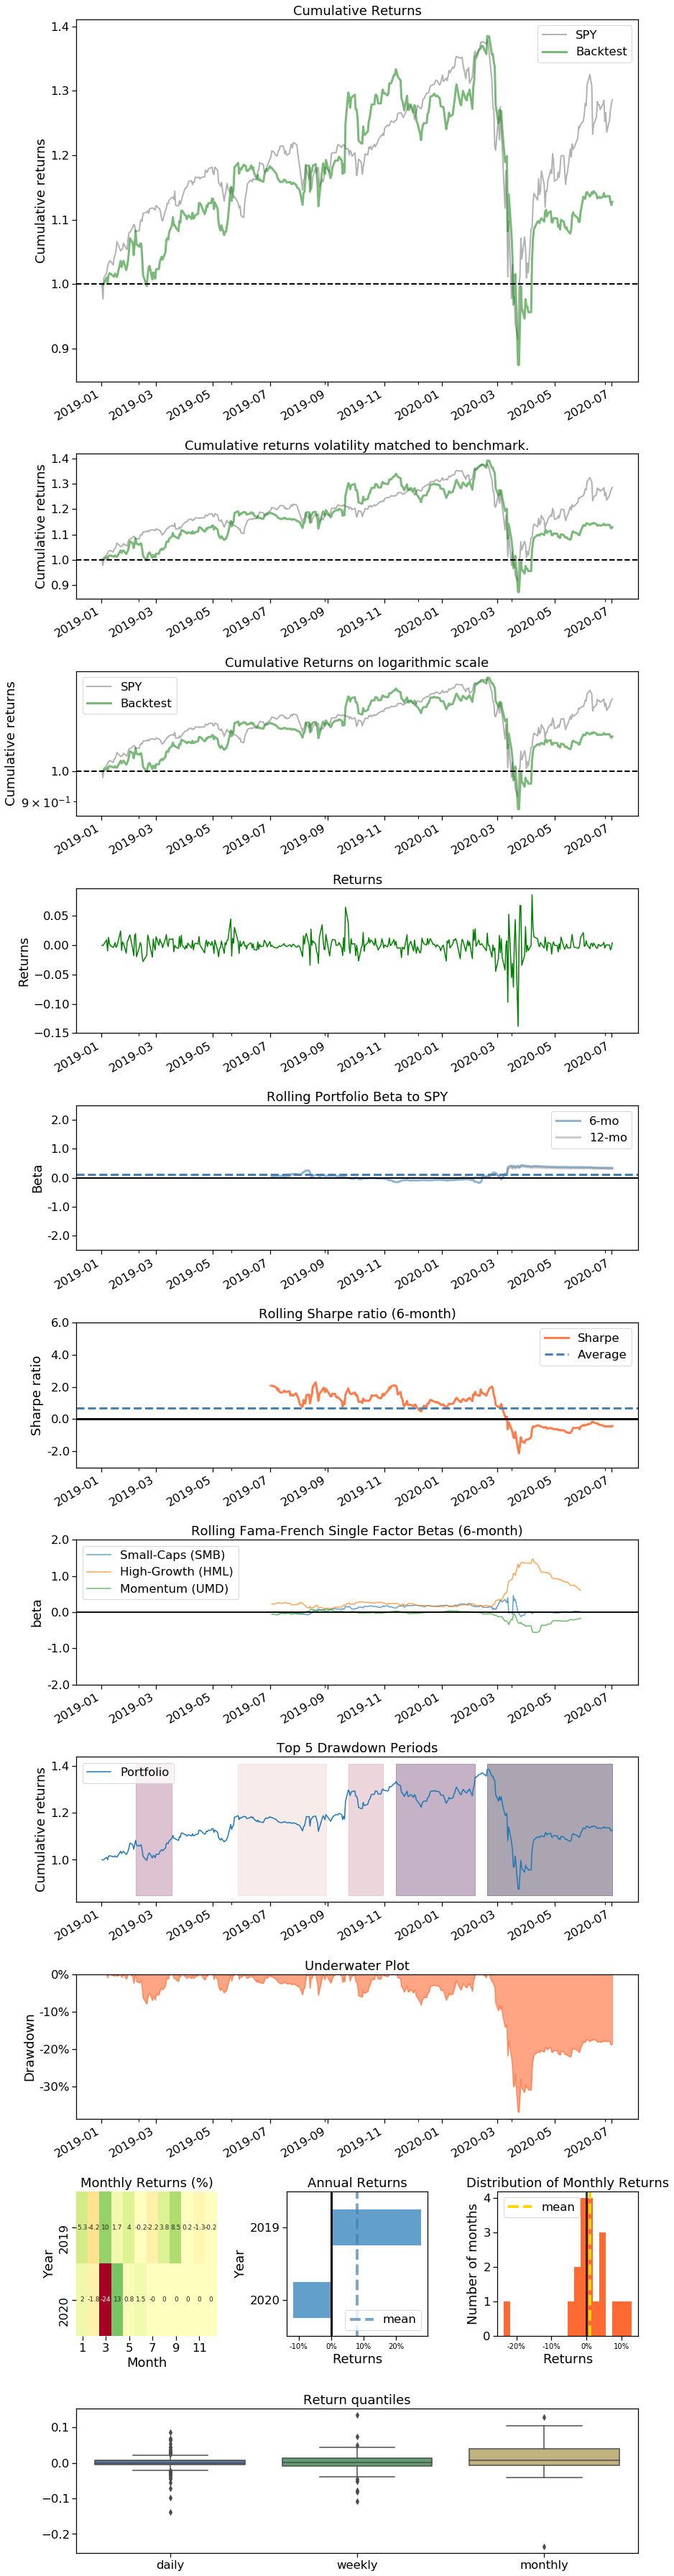

In [26]:
returns,a,b,c = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [5]:
perf.portfolio_value.to_csv('125d version.csv')